# Vulnerability Hatstall

![Categorization](figs/An-Illustrated-Guide-to-Categorizing-Yourself_HERO.png "Logo")

# Objective

Sorting vulnerabilities from different scanners using a machine learning model.

![objective](figs/hatstall_project.png "hatstall_project")

# Scope

Due to bigness of this project, we are only classify all the vulnerabilities from Openvas, mainly because it is open source and its plugins can be downloaded from free.

![objective](figs/hatstall_openvas.png "Hatstall Openvas")

Currently there is a [dataset](https://www.kaggle.com/vsathiamoo/cve-common-vulnerabilities-and-exposures) in Kaggle and it compiles information about Common Vulnerabilities and Exposures(CVE) but that information normally comes in the tools plugins or databases and results, so it is not useful for our purposes. Also, there is a [kernel](https://www.kaggle.com/walterhaydock/cybersecurity-vulnerability-analysis-with-k-means) but they focus in vulnerabilities and our project want to focus on patching vulnerabilities.  

Also, there are a lot of information about [vulnerability management](#References) however it is quite difficult to find information about how to do vulnerability management. Like many other topics there is not only one way to do vulnerability management nor the "properly" way to do it, so in this case we are going to implement the way we know it and it worked for us during long time. The steps we normally use are explained deeper in the [Reasons](#Reasons) section.

# Reasons

- Mainly because we need it in our job. We have been looking for the way to make vulnerability management easier.
- Many companies work with a lot of vulnerabilities scanners, and this is the way to normalize the results for all of those tools.
- We have never found anybody who works in something similar.
- There are not many data-science projects about cybersecurity, just search in [kaggle](https://www.kaggle.com) "cycbersecurity" and you will found out.
- It is a good way to practice data cleaning and wrangling and change our mind paradigm.
- Because I want and I can 😜

The main reason for working in this project is to make easier the vulnerability management. Many people thinks that it is simple as just as run a vulnerability scan and then just give a simple report to the responsible team for patching however there is nothing more wrong than that. Vulnerability management is very important activity to analyze those reports, one of those steps consist in **categorizing vulnerabilities in groups**, filter all the important one, then we have got to reduce false positives and group as much as possible the vulnerabilities that can be solved by the same patch to make the work easier for patching team. Probably, one of the most difficult job is to categorize all of those vulnerabilities, especially if you have got different tools that work and generate results in different ways.

The scope of this project is only about categorizing vulnerabilities from [Openvas](http://www.openvas.org/) because the tool is open source and its data is open to public. this might be called the first "subproject" from a bigger one. Categorizing too many vulnerabilities could be an exhaustive work, especially if there come from many tools. 

Many people would think the scope of this project is quite short however we plan to go further and make this project much more elegant, in the future we want to implement this to other tools like [Qualys](https://www.qualys.com/) or [Insightvm](https://www.rapid7.com/products/insightvm/), we are also focusing only in "plugins" or "knowledge database" because we are not going to run any vulnerability scan and we do not have the resources and open data to do this, imagine that nobody who has common sense is going to public their vulnerabilities to Internet, that is going to make hackers' job easier. However our job is going to be useful because companies will be able to join their vulnerabilities results with the output we generated and they can enrich their results with the data we categorized. Also we plan to use analytics and/or other machine learning models that can suggest to patching team things like "Close port 8900 on this servers and you will be less vulnerable to Elastic vulnerabilities".

# Data

- We are going to work with official feeds from Openvas, data is public.

![Data](figs/catching_openvas.png "OpenvasData")

We are going to work with Openvas because it is free and open source scanner, data is available for public, and it can be downloaded from its [official web](http://dl.greenbone.net/community-nvt-feed-current.tar.bz2). 

Data is subdivided in different folders and sub-folders, I worked in a python Script in the past that used to go through those folders, read the different files, look for an unique id and categorize those vulnerabilities with regular expressions and string functions, apply a categorization and then write the output in a csv file. The current script works quite good but I strongly think a machine learning model would work much better.

These are the categories I create with the current script: 

#### Useful categories for vulnerability management

- Update or patch installation
- End of life Platform
- Informational
- Workaround
- No solution or patch available
- Configuration changes

#### Categories that belongs only to Openvas but are not useful for vulnerability management.

- To classify
- GSHB Family
- NMAP Family

In [45]:
def get_block_of_text(start, end, file_object):
    """Get just the block of text that we need it to create the dataset"""
    recording_mode = False
    for line in file_object:
        if not recording_mode:
            if line.decode().replace(' ', '').rstrip().startswith(start):
                recording_mode = True
        elif line.decode().rstrip().replace(' ', '').rstrip().startswith(end):
            recording_mode = False
        else:
            yield line

# Execution plan

The most difficult and tedious work is the cleaning, the data come from different files divided in many directories and subdirectories. We are going to follow those steps: 

1. Download the files from the [Openvas](http://dl.greenbone.net/community-nvt-feed-current.tar.bz2) web.
2. Write a script that read every single raw document (plugin) and parse the data. We might spend 90% of the time here.
3. Structure the data (JSON, CSV or SQL).
4. Represent the [words in vectors](https://www.tensorflow.org/tutorials/representation/word2vec) or use [Bert](https://github.com/google-research/bert) as word embedding.
5. Label the output with the categories showed in the [Data](#Data) section.
6. Deal with "oversampling".
7. Apply an explanatory classification supervised model. We got to choose between Naive Bayes, Logistic Regression or Tree desicion, or maybe all of them?.
8. Test the model.

In [44]:
with open('../PluginsCategorization/Openvas/Samples/gb_adobe_acrobat_2017_apsb19-02_win.nasl','rb') as filename:
    myblock = get_block_of_text("if(description)", "include(", filename)
    for block in myblock:
        print(block)

b'{\n'
b'  script_oid("1.3.6.1.4.1.25623.1.0.814805");\n'
b'  script_version("$Revision: 13316 $");\n'
b'  script_cve_id("CVE-2018-16011", "CVE-2018-16018");\n'
b'  script_tag(name:"cvss_base", value:"9.3");\n'
b'  script_tag(name:"cvss_base_vector", value:"AV:N/AC:M/Au:N/C:C/I:C/A:C");\n'
b'  script_tag(name:"last_modification", value:"$Date: 2019-01-28 08:41:51 +0100 (Mon, 28 Jan 2019) $");\n'
b'  script_tag(name:"creation_date", value:"2019-01-04 11:36:03 +0530 (Fri, 04 Jan 2019)");\n'
b'\n'
b'  script_name("Adobe Acrobat 2017 Security Updates(apsb19-02)-Windows");\n'
b'\n'
b'  script_tag(name:"summary", value:"This host is installed with Adobe Acrobat 2017\n'
b'  and is prone to multiple vulnerabilities.");\n'
b'\n'
b'  script_tag(name:"vuldetect", value:"Checks if a vulnerable version is present\n'
b'  on the target host.");\n'
b'\n'
b'  script_tag(name:"insight", value:"Multiple flaws exist due to,\n'
b'\n'
b'  - Use after free error.\n'
b'\n'
b'  - Security bypass error.");\n'
b

In [35]:
import pandas as pd
openvas_df = pd.read_csv('../PluginsCategorization/Openvas/Output/OpenvasSample.csv')
openvas_df.sample(5)

,OID,SolutionCategory,PluginFile,PluginFamily
1291,812657,ToDiscard,gb_master_ip_camera01_detect.nasl,Product detection
11157,103608,ToClassify,gb_dotProject_lfi_11_12.nasl,Web application abuses
28943,803513,ToClassify,gb_nmap6_http_malware_host.nasl,Nmap NSE
23500,122863,Patch installation,ELSA-2016-0074.nasl,Oracle Linux Local Security Checks
42450,863399,Patch installation,gb_fedora_2011_9652_system-config-firewall_fc1...,Fedora Local Security Checks


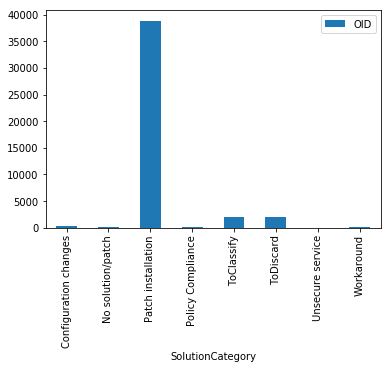

In [24]:
openvas_df.groupby(['SolutionCategory']).count().loc[:,['OID']].plot.bar();

# Tools
![Categorization](figs/toolsdia.png "Logo")

![R](figs/r-code-or-alien-language.jpg "R")

## Main Tools

- Python as programming language. (**F\*\* "R"**)
- Jupyter
- Altair for visualizations
- Machine Learning framework (Keras or Sklearn)

## Contingency tools

- Splunk for cleaning and visualization.
- Gemsim for NLP.

We plan to use python (**F\*\* "R"**) as programming language and other open source tools to commit our achievement. We also might use [Splunk](https://www.splunk.com) to speed the cleaning data work because we have been working with Splunk for years and we know how to use it perfectly, we might use it to make some operations that can be more difficult to do with pandas, however our priority are opensource tools.

We might use [Gemsim](https://radimrehurek.com/gensim/index.html) to work in semantic words.

# References
- http://www.lmgtfy.com/?q=vulnerability+management
- https://whatis.techtarget.com/definition/Vulnerability_management
- https://www.tripwire.com/state-of-security/vulnerability-management/what-is-vulnerability-management-anyway/
- https://www.kaggle.com/vsathiamoo/cve-common-vulnerabilities-and-exposures
- https://www.kaggle.com/walterhaydock/cybersecurity-vulnerability-analysis-with-k-means

# Ham for teacher
![Categorization](figs/jamónprofe.jpg "Ham")